In [24]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

filename = "/data/fast0/datasets/Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


In [25]:
# Put data in a data frame
das = np.transpose([chan[750] for chan in f['DAS Data']])

# Might want to try this later:
# das = np.log10(np.transpose([chan[750] for chan in f['DAS Data']]))

discharge = np.array(f['Discharge'])
df = pd.DataFrame(data={'das':das,'discharge':discharge})

In [26]:
das_data_all = f['DAS Data'][:]
discharge_1 = f['Discharge'][:]

df_all_chan = pd.DataFrame(das_data_all)
df_all_chan['Discharge'] = discharge_1
df_all_chan.head()

,0,1,2,3,4,5,6,7,8,9,...,2487,2488,2489,2490,2491,2492,2493,2494,2495,Discharge
0,1737.318436,1932.321258,1788.269101,3706.977556,1831.756626,1768.674227,1908.850695,3690.341997,1804.145150,2437.436803,...,3603.932847,2066.070800,2215.669390,1881.772352,3990.883595,1584.965970,1787.281257,1862.912440,4160.545583,9.947179
1,8161.349279,8245.783723,8118.189935,528.834231,468.890511,714.714310,728.051775,158.440806,82.719811,116.949415,...,8238.452283,8204.901437,8194.671705,8228.769841,8211.066134,8229.370787,8218.436955,8210.143402,8178.032001,9.934657
2,8242.942236,8205.640252,8093.980026,510.832905,451.884623,709.510655,709.932307,153.715844,83.404382,116.112236,...,8184.500407,8221.490571,8202.429647,8194.927561,8197.675324,8188.718827,8189.658071,8225.017259,8163.918322,9.929290
3,8159.780047,8196.654224,8113.873839,489.734947,438.657688,690.418208,701.896139,158.058233,83.003254,112.787627,...,8173.860868,8156.187127,8151.113841,8235.843141,8145.360321,8192.392266,8169.275389,8129.926491,8161.652382,9.923923
4,8198.498465,8161.470921,8120.452338,521.425978,444.272741,689.710217,695.164917,160.246640,84.054029,111.125592,...,8198.827286,8234.815465,8219.987333,8140.961605,8193.517740,8157.154485,8241.648596,8229.194191,8234.212679,9.918557


Text(0, 0.5, 'Discharge')

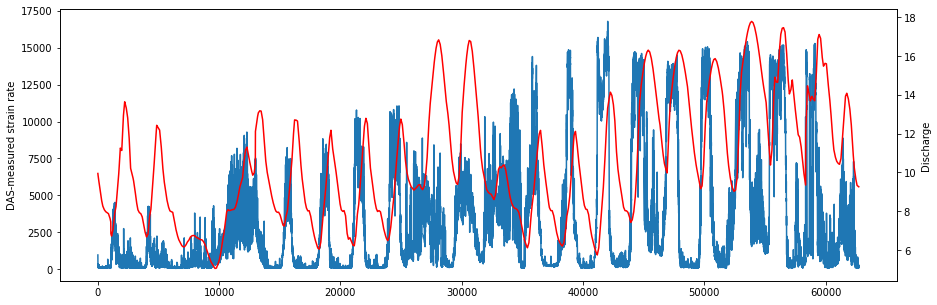

In [27]:
# Plot the raw data

fig,ax=plt.subplots(figsize=(15,5))
ax.plot(das)
ax.set_ylabel('DAS-measured strain rate')
ax2=plt.twinx()
ax2.plot(discharge,'-r')
ax2.set_ylabel('Discharge')

In [28]:
# Split the data
column_indices = {name: i for i, name in enumerate(df_all_chan.columns)}
n = len(df_all_chan)

train_df = df_all_chan[0:int(n*0.7)]
val_df = df_all_chan[int(n*0.7):int(n*0.9)]
test_df = df_all_chan[int(n*0.9):]

In [29]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [23]:
# Visualize the normalized data
df_std = (df_all_chan - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

ValueError: The number of FixedLocator locations (2497), usually from a call to set_ticks, does not match the number of ticklabels (2).

Error in callback <function flush_figures at 0x7fa16c155040> (for post_execute):


KeyboardInterrupt: 

In [46]:
class WindowGenerator():
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)

        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


    def __init__(self, input_width, label_width, shift,
               train_df=train_df, 
               val_df=val_df, 
               test_df=test_df,
               label_columns=None,
               input_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Do the same for the input column indices.
        self.input_columns = input_columns
        if input_columns is not None:
            self.input_columns_indices = {name: i for i, name in
                                        enumerate(input_columns)}
        self.input_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column name(s): {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def split_window(self, ds):
        inputs = ds[:, self.input_slice, :]
        labels = ds[:, self.labels_slice, :]
#         print(inputs)

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
            
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

AttributeError: 'list' object has no attribute 'type'

In [54]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    label_columns=['Discharge'],
    #input_columns=['das']
    input_columns=list(np.arange(0,2308,1))
)
single_step_window

Total window size: 1
Input indices: [0]
Input column name(s): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 20

In [63]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [56]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [57]:
history = compile_and_fit(linear, single_step_window)

val_performance={}
performance={}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.7360 - mean_absolute_error: 0.5654 - val_loss: 10.8806 - val_mean_absolute_error: 2.7487
Epoch 2/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.6713 - mean_absolute_error: 0.4863 - val_loss: 7.5233 - val_mean_absolute_error: 2.1121
Epoch 3/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.4341 - mean_absolute_error: 0.4241 - val_loss: 6.9965 - val_mean_absolute_error: 2.0420
Epoch 4/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.5847 - mean_absolute_error: 0.4331 - val_loss: 6.1288 - val_mean_absolute_error: 1.8668
Epoch 5/20
1373/1373 [==============================] - 9s 6ms/step - loss: 0.2990 - mean_absolute_error: 0.3754 - val_loss: 11.6640 - val_mean_absolute_error: 2.6714
Epoch 6/20
1373/1373 [==============================] - 9s 7ms/step - loss: 0.5644 - mean_absolute_error: 0.4574 - val_loss: 3.0851 - val_mean_absolute_error: 1.2944
Ep

ValueError: x and y must have same first dimension, but have shapes (73856,) and (32,)

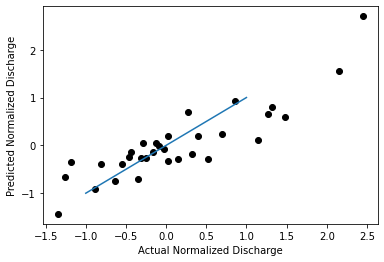

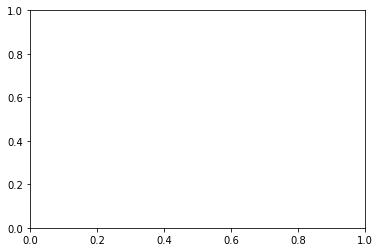

In [59]:
inputs, labels = single_step_window.example

predictions = np.array(linear(inputs)).flatten()
inputs = np.array(inputs).flatten()
labels = np.array(labels).flatten()

plt.subplots()
plt.plot(labels,predictions,'ok')
plt.plot((-1,1),(-1,1))
plt.xlabel('Actual Normalized Discharge')
plt.ylabel('Predicted Normalized Discharge')

plt.subplots()
plt.plot(inputs, labels,'ok')
# for xx, yy in single_step_window.val.take(5):
#     plt.plot(np.array(xx[:,0,:]).flatten(),np.array(yy).flatten(),'or')
plt.xlabel('Actual Normalized DAS')
plt.ylabel('Normalized Discharge (Actual and Modeled)')
weights=linear.layers[0].kernel[:,0].numpy()
biases=linear.layers[0].bias.numpy()
plt.plot((-1,3.0),weights[0]*np.array((-1,3.0))+biases[0])

# Compare to linear least squares
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(inputs,labels)
plt.plot((-1,3.0),slope*np.array((-1,3.0))+intercept)

In [64]:
multi_step_window = WindowGenerator(
    input_width=100, label_width=1, shift=0,
    label_columns=['Discharge'],
    input_columns=list(np.arange(0,2308,1)))
# multi_step_window

In [61]:
history = compile_and_fit(linear, multi_step_window)

Epoch 1/20
1342/1342 [==============================] - 403s 299ms/step - loss: 0.3231 - mean_absolute_error: 0.4377 - val_loss: 2.7029 - val_mean_absolute_error: 1.3213
Epoch 2/20
1342/1342 [==============================] - 486s 361ms/step - loss: 0.3008 - mean_absolute_error: 0.4226 - val_loss: 2.7343 - val_mean_absolute_error: 1.3293
Epoch 3/20
1342/1342 [==============================] - 525s 391ms/step - loss: 0.3005 - mean_absolute_error: 0.4225 - val_loss: 2.4309 - val_mean_absolute_error: 1.2462
Epoch 4/20
1342/1342 [==============================] - 521s 388ms/step - loss: 0.3001 - mean_absolute_error: 0.4226 - val_loss: 2.7638 - val_mean_absolute_error: 1.3580
Epoch 5/20
1342/1342 [==============================] - 516s 384ms/step - loss: 0.2918 - mean_absolute_error: 0.4179 - val_loss: 2.8437 - val_mean_absolute_error: 1.3650


In [62]:
val_performance['Multistep_Linear'] = linear.evaluate(multi_step_window.val)
performance['Multistep_Linear'] = linear.evaluate(multi_step_window.test, verbose=0)
performance

361/361 [==============================] - 131s 345ms/step - loss: 2.8437 - mean_absolute_error: 1.3650


{'Linear': [4.883157253265381, 1.8943331241607666],
 'Multistep_Linear': [1.5972886085510254, 1.072415828704834]}

In [65]:
history = compile_and_fit(lstm_model, multi_step_window)

Epoch 1/20
1371/1371 [==============================] - 45s 32ms/step - loss: 0.0692 - mean_absolute_error: 0.1642 - val_loss: 1.7446 - val_mean_absolute_error: 1.0769
Epoch 2/20
1371/1371 [==============================] - 44s 32ms/step - loss: 0.0172 - mean_absolute_error: 0.0896 - val_loss: 1.9061 - val_mean_absolute_error: 1.1347
Epoch 3/20
1371/1371 [==============================] - 44s 32ms/step - loss: 0.0145 - mean_absolute_error: 0.0820 - val_loss: 1.8448 - val_mean_absolute_error: 1.1118


In [66]:
val_performance['Multistep_LSTM'] = lstm_model.evaluate(multi_step_window.val)
performance['Multistep_LSTM'] = lstm_model.evaluate(multi_step_window.test, verbose=0)
performance

391/391 [==============================] - 11s 11ms/step - loss: 1.8448 - mean_absolute_error: 1.1118


{'Linear': [4.883157253265381, 1.8943331241607666],
 'Multistep_Linear': [1.5972886085510254, 1.072415828704834],
 'Multistep_LSTM': [1.976258635520935, 1.1816800832748413]}